In [2]:
import webbrowser
import pandas as pd
import gspread
import gspread_dataframe as gd
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials # Đọc dữ liệu từ googlesheets
from df2gspread import df2gspread as d2g # Ghi dữ liệu lên googlesheets
from pprint import pprint
from googleapiclient import discovery
import pypyodbc #connect với sql server
import numpy as np #Tính toán (=,-,*,/)
import sqlalchemy #query trực tiếp
import urllib #connect url
import time #
import datetime as dt
import pymssql
import random
import math
import calendar
import warnings
import itertools
warnings.filterwarnings("ignore")


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [428]:
#connect server
db = pypyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                        "Server=103.69.193.246;"
                        "Database=dwh;"
                        "uid=dwh;pwd=F88!23456789")
print('Connected to SQL server: DWH')


Connected to SQL server: DWH


In [5]:
def get_n_days(nday):
    return (today+dt.timedelta(days=nday)).strftime("%Y-%m-%d")
number_day=-1

In [6]:
# Get the first day of this month
todayDate = dt.date.today()
first_date_of_month = todayDate.replace(day=1)

In [7]:
first_date_of_month = dt.datetime.strftime(first_date_of_month, "%Y-%m-%d")

In [8]:
open_str = """Declare @ext_date date= '"""+first_date_of_month+"""'
select le.EXTRAC_DATE,support_staff,created_staff,ShopCode,le.CodeNo,Customer,
NAME categoryname,OpenHour,InitTime,complete 
from [dwh].[dbo].OPEN_CLOSE_CONTRACT_BY_TIME le 
left join [dwh].[dbo].W_CATEGORY_D cate on cate.CODE=le.CategoryCode 
left join (select codeno,FirstSupportID,u.USER_CODE support_staff,u2.USER_CODE created_staff,
ShopCode,InitTime 
from [dwh].[dbo].pawn pa1 
left join [dwh].[dbo].W_USER_F u on pa1.firstsupportid=u.USER_WID 
left join [dwh].[dbo].W_USER_F u2 on pa1.CreatedBy=u2.USER_WID 
where pa1.status not in (15,22,11))pa on le.CodeNo=pa.CodeNo 
left join (select PAWN_WID,CONTRACT_NO,min(CREATED)complete from [dwh].[dbo].W_PAWN_TRANSACTION_F 
where action_name like N'Cho vay' 
group by PAWN_WID,CONTRACT_NO)trans 
on trans.CONTRACT_NO=le.CodeNo where OpenHour is not null and cast(OpenHour as date) >= dateadd(m, -1, @ext_date)"""

In [37]:
open_data=pd.read_sql_query(open_str,db)

In [38]:
open_data['init_to_comple']=(pd.to_datetime(open_data['complete'])-open_data.inittime).dt.seconds/60

In [39]:
open_data.columns

Index(['extrac_date', 'support_staff', 'created_staff', 'shopcode', 'codeno',
       'customer', 'categoryname', 'openhour', 'inittime', 'complete',
       'init_to_comple'],
      dtype='object')

In [91]:
open_data['categoryname'].unique()

array(['Đăng ký xe máy', 'Laptop', 'Điện thoại', 'Trang sức',
       'Đăng ký Ô tô', 'Xe máy', 'Máy tính bảng', 'Đồng hồ', 'Ô tô',
       'Máy ảnh', 'Sim điện thoại', 'Tài sản khác', 'Đồng hồ cao cấp',
       'Thiết bị định vị'], dtype=object)

In [150]:
open_data.groupby('categoryname')['init_to_comple'].describe()

,count,mean,std,min,25%,50%,75%,max
categoryname,,,,,,,,
Laptop,2906.0,19.099513,21.082727,1.233333,9.166667,14.800000,23.000000,548.733333
Máy tính bảng,280.0,15.813571,18.755269,2.466667,7.162500,11.808333,18.470833,246.950000
Máy ảnh,142.0,36.687207,33.860527,5.550000,17.370833,26.291667,44.200000,198.400000
Sim điện thoại,3.0,17.038889,7.928593,8.383333,13.583333,18.783333,21.366667,23.950000
Thiết bị định vị,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trang sức,404.0,12.504208,15.200287,1.383333,6.145833,9.025000,13.512500,179.416667
Tài sản khác,6.0,62.730556,82.093674,6.266667,13.904167,38.458333,56.750000,224.633333
Xe máy,2305.0,15.040123,14.159600,1.933333,7.683333,11.833333,17.800000,266.416667
Ô tô,66.0,115.791414,89.016604,16.150000,67.758333,92.075000,135.337500,517.316667


In [76]:
#  outliers selection
def lower_outlier_selection(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
#     upper_range = Q3 + (1.5 * IQR)
    return lower_range

In [77]:
#  outliers selection
def upper_outlier_selection(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
#     lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return upper_range

#  Thời gian tạo lập HĐ DKXM

In [298]:
motor_title_describe = open_data[open_data['categoryname'] == 'Đăng ký xe máy'].describe()

In [299]:
motor_title_describe_transposed = motor_title_describe.T

motor_title_describe_transposed = motor_title_describe_transposed.reset_index() 

In [300]:
motor_title_describe_transposed['key'] = 1

In [301]:
motor_title_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max,key
0,init_to_comple,17488.0,62.891257,58.544472,4.283333,32.8625,45.983333,69.066667,812.916667,1


In [306]:
motor_title_open_data = open_data[open_data['categoryname'] == 'Đăng ký xe máy']

motor_title_open_data['key'] = 1

motor_title_open_data = motor_title_open_data.merge(motor_title_describe_transposed, on = 'key', how = 'left')

In [308]:
motor_title_open_data.columns

Index(['extrac_date', 'support_staff', 'created_staff', 'shopcode', 'codeno',
       'customer', 'categoryname', 'openhour', 'inittime', 'complete',
       'init_to_comple', 'key', 'index', 'count', 'mean', 'std', 'min', '25%',
       '50%', '75%', 'max'],
      dtype='object')

In [309]:
motor_title_open_data['init_to_comple'].describe()

count    17488.000000
mean        62.891257
std         58.544472
min          4.283333
25%         32.862500
50%         45.983333
75%         69.066667
max        812.916667
Name: init_to_comple, dtype: float64

In [310]:
motor_title_open_data[motor_title_open_data['init_to_comple']< motor_title_open_data['25%']]['init_to_comple'].describe()

count    4372.000000
mean       25.368142
std         5.287823
min         4.283333
25%        21.950000
50%        26.283333
75%        29.600000
max        32.850000
Name: init_to_comple, dtype: float64

(array([  2.,   3.,   5.,  13.,  24.,  48.,  77.,  78., 126., 168., 173.,
        242., 325., 334., 392., 413., 507., 473., 498., 471.]),
 array([ 4.28333333,  5.71166667,  7.14      ,  8.56833333,  9.99666667,
        11.425     , 12.85333333, 14.28166667, 15.71      , 17.13833333,
        18.56666667, 19.995     , 21.42333333, 22.85166667, 24.28      ,
        25.70833333, 27.13666667, 28.565     , 29.99333333, 31.42166667,
        32.85      ]),
 <a list of 20 Patch objects>)

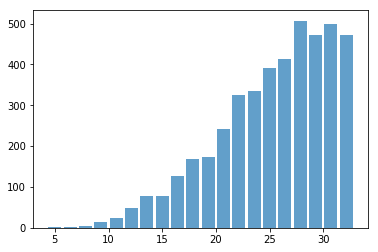

In [311]:
plt.hist(motor_title_open_data[motor_title_open_data['init_to_comple']<= motor_title_open_data['25%']]['init_to_comple'], bins=20, alpha=0.7, rwidth=0.85)

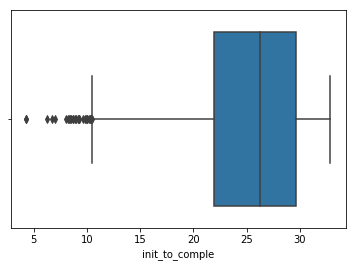

In [312]:
sns.boxplot(motor_title_open_data[motor_title_open_data['init_to_comple']<= motor_title_open_data['25%']]['init_to_comple'])

In [314]:
motor_title_lower_outlier = lower_outlier_selection(motor_title_open_data[motor_title_open_data['init_to_comple']<= motor_title_open_data['25%']]['init_to_comple'])

In [315]:
motor_title_lower_outlier

10.474999999999996

In [393]:
motor_title_lower_min = motor_title_lower_outlier
motor_title_lower_max = float(motor_title_describe_transposed['25%'])*0.5

In [84]:
# Kết quả chọn mẫu:
#  HĐ có thời gian tạo lập <= lower_outlier_detection =>100% mẫu
# HĐ có thời gian tạo lập > lower_outlier_detection  và nhỏ hơn 25%*0.5 => chọn 20% mẫu


In [316]:
motor_title_open_data[motor_title_open_data['init_to_comple']> motor_title_open_data['75%']]['init_to_comple'].describe()

count    4371.000000
mean      131.248494
std        83.281397
min        69.083333
25%        80.958333
50%        99.866667
75%       143.808333
max       812.916667
Name: init_to_comple, dtype: float64

(array([2.408e+03, 8.630e+02, 3.860e+02, 2.080e+02, 1.500e+02, 1.050e+02,
        6.900e+01, 5.600e+01, 3.900e+01, 2.000e+01, 2.700e+01, 1.200e+01,
        1.200e+01, 8.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 69.08333333, 106.275     , 143.46666667, 180.65833333,
        217.85      , 255.04166667, 292.23333333, 329.425     ,
        366.61666667, 403.80833333, 441.        , 478.19166667,
        515.38333333, 552.575     , 589.76666667, 626.95833333,
        664.15      , 701.34166667, 738.53333333, 775.725     ,
        812.91666667]),
 <a list of 20 Patch objects>)

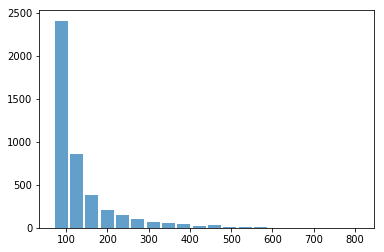

In [317]:
plt.hist(motor_title_open_data[motor_title_open_data['init_to_comple']> motor_title_open_data['75%']]['init_to_comple'], bins=20, alpha=0.7, rwidth=0.85)

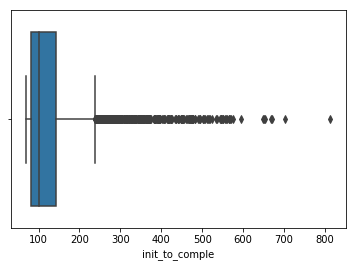

In [318]:
sns.boxplot(motor_title_open_data[motor_title_open_data['init_to_comple']> motor_title_open_data['75%']]['init_to_comple'])

In [319]:
motor_title_upper_outlier = upper_outlier_selection(motor_title_open_data[motor_title_open_data['init_to_comple']> motor_title_open_data['75%']]['init_to_comple'])

In [396]:
motor_title_upper_outlier*2

476.16666666666663

In [397]:
motor_title_upper_min = motor_title_upper_outlier
motor_title_upper_max = motor_title_upper_outlier*2

In [ ]:
# Kết quả chọn mẫu:
#  HĐ có thời gian tạo lập >= upper_outlier_detection*2 =>100% mẫu
# HĐ có thời gian tạo lập <upper_outlier_detection*2 và lớn hơn outlier=> chọn 20% mẫu


Thời gian tạo lập HĐ DKOT

In [321]:
car_title_describe = open_data[open_data['categoryname'] == 'Đăng ký Ô tô'].describe()

car_title_describe_transposed = car_title_describe.T

car_title_describe_transposed = car_title_describe_transposed.reset_index() 

In [322]:
car_title_describe_transposed['key'] = 1

In [324]:
car_title_open_data = open_data[open_data['categoryname'] == 'Đăng ký Ô tô']

car_title_open_data['key'] = 1

car_title_open_data = car_title_open_data.merge(car_title_describe_transposed, on = 'key', how = 'left')

In [325]:
car_title_open_data['init_to_comple'].describe()

count     860.000000
mean      147.808682
std       113.990387
min        15.333333
25%        75.962500
50%       113.908333
75%       183.983333
max      1353.383333
Name: init_to_comple, dtype: float64

(array([ 1.,  1.,  2.,  2.,  3.,  7.,  5.,  6.,  6., 12., 21., 13., 11.,
        12., 17., 16., 23., 18., 21., 18.]),
 array([15.33333333, 18.33916667, 21.345     , 24.35083333, 27.35666667,
        30.3625    , 33.36833333, 36.37416667, 39.38      , 42.38583333,
        45.39166667, 48.3975    , 51.40333333, 54.40916667, 57.415     ,
        60.42083333, 63.42666667, 66.4325    , 69.43833333, 72.44416667,
        75.45      ]),
 <a list of 20 Patch objects>)

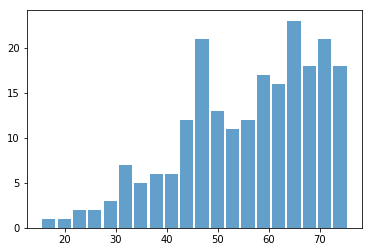

In [326]:
plt.hist(car_title_open_data[car_title_open_data['init_to_comple']<= car_title_open_data['25%']]['init_to_comple'], bins=20, alpha=0.7, rwidth=0.85)

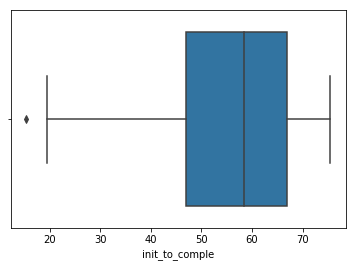

In [327]:
sns.boxplot(car_title_open_data[car_title_open_data['init_to_comple']<= car_title_open_data['25%']]['init_to_comple'])

In [328]:
car_title_lower_outlier = lower_outlier_selection(car_title_open_data[car_title_open_data['init_to_comple']<= car_title_open_data['25%']]['init_to_comple'])

In [329]:
car_title_lower_outlier

16.879166666666656

In [399]:
car_title_lower_min = car_title_lower_outlier
car_title_lower_max = car_title_lower_outlier*1.5

In [ ]:
# HĐ tạo trong vòng nhỏ hơn dkot_lower_outlier
# chọn 50% mẫu trong khoảng >dkot_lower_outlier  và dkot_lower_outlier*1.5 =>chon 50% số mẫu

In [330]:
car_title_open_data[car_title_open_data['init_to_comple']> car_title_open_data['75%']]['init_to_comple'].describe()

count     215.000000
mean      297.591860
std       131.854573
min       184.883333
25%       212.875000
50%       254.000000
75%       340.641667
max      1353.383333
Name: init_to_comple, dtype: float64

(array([95., 43., 29., 22.,  9., 10.,  1.,  3.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 184.88333333,  243.30833333,  301.73333333,  360.15833333,
         418.58333333,  477.00833333,  535.43333333,  593.85833333,
         652.28333333,  710.70833333,  769.13333333,  827.55833333,
         885.98333333,  944.40833333, 1002.83333333, 1061.25833333,
        1119.68333333, 1178.10833333, 1236.53333333, 1294.95833333,
        1353.38333333]),
 <a list of 20 Patch objects>)

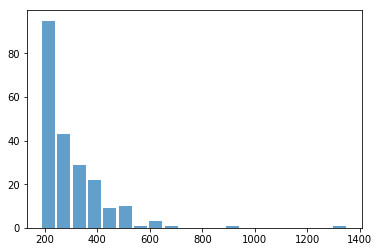

In [331]:
plt.hist(car_title_open_data[car_title_open_data['init_to_comple']> car_title_open_data['75%']]['init_to_comple'], bins=20, alpha=0.7, rwidth=0.85)

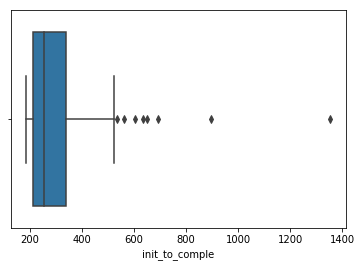

In [332]:
sns.boxplot(car_title_open_data[car_title_open_data['init_to_comple']> car_title_open_data['75%']]['init_to_comple'])

In [333]:
car_title_open_data[car_title_open_data['init_to_comple']> car_title_open_data['75%']]['init_to_comple'].describe()

count     215.000000
mean      297.591860
std       131.854573
min       184.883333
25%       212.875000
50%       254.000000
75%       340.641667
max      1353.383333
Name: init_to_comple, dtype: float64

In [334]:
car_title_upper_outlier = upper_outlier_selection(car_title_open_data[car_title_open_data['init_to_comple']> car_title_open_data['75%']]['init_to_comple'])

In [398]:
car_title_upper_min = float(car_title_describe_transposed['75%'])
car_title_upper_max = car_title_upper_outlier

In [90]:
# Chọn mẫu
#  100% các HĐ có thời gian tạo lập>= upper_outlier
#  20% số lượng mẫu các HĐ >75% và upper_outlier

Xe máy

In [281]:
open_data_motor = open_data[open_data['categoryname'] == 'Xe máy']
open_data_motor = open_data_motor[open_data_motor['init_to_comple'].isnull() == False]

In [282]:
motor_describe = open_data_motor.describe()

motor_describe_transposed = motor_describe.T

motor_describe_transposed = motor_describe_transposed.reset_index() 

(array([1.523e+03, 5.890e+02, 1.140e+02, 4.100e+01, 1.700e+01, 8.000e+00,
        5.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1.93333333,  15.1575    ,  28.38166667,  41.60583333,
         54.83      ,  68.05416667,  81.27833333,  94.5025    ,
        107.72666667, 120.95083333, 134.175     , 147.39916667,
        160.62333333, 173.8475    , 187.07166667, 200.29583333,
        213.52      , 226.74416667, 239.96833333, 253.1925    ,
        266.41666667]),
 <a list of 20 Patch objects>)

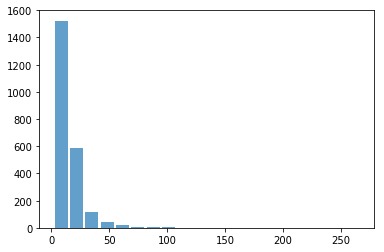

In [335]:
plt.hist(open_data_motor['init_to_comple'], bins = 20, alpha=0.7, rwidth=0.85 )

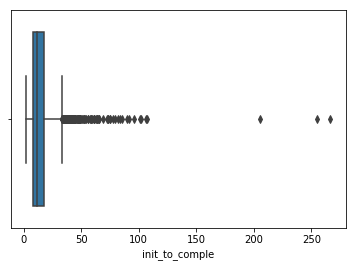

In [336]:
sns.boxplot(open_data_motor['init_to_comple'])

In [337]:
motor_upper_outlier = upper_outlier_selection(open_data_motor['init_to_comple'])

In [379]:
motor_lower_outlier = float(motor_describe_transposed['25%'])

In [400]:
motor_upper_outlier

32.975

In [414]:
motor_upper_min = motor_upper_outlier
motor_upper_max = motor_upper_outlier*2

In [120]:
#  Kết quả ngưỡng cảnh báo
#  HĐ có thời gian mở <25% hoặc lớn hơn upper_outlier*2 =>100%
# 20% mẫu từ upper_outlier_selection đến upper_outlier*2

In [286]:
car_open_data = open_data[open_data['categoryname'] == 'Ô tô']
car_open_data = car_open_data[car_open_data['init_to_comple'].isnull() == False]

In [287]:
car_describe = car_open_data.describe()

car_describe_transposed = car_describe.T

car_describe_transposed = car_describe_transposed.reset_index() 

In [288]:
car_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,66.0,115.791414,89.016604,16.15,67.758333,92.075,135.3375,517.316667


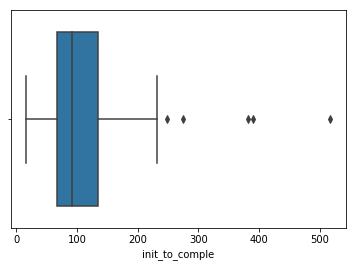

In [338]:
sns.boxplot(car_open_data['init_to_comple'])

In [340]:
car_open_data[car_open_data['init_to_comple']<30]

,extrac_date,support_staff,created_staff,shopcode,codeno,customer,categoryname,openhour,inittime,complete,init_to_comple
17063,2020-10-20,F01137,F01137,NAN0185,HÐCC/NAN0185/2010/60,Nguyễn Trường Sơn,Ô tô,2020-10-20 19:20:45.693,2020-10-20 19:19:23,2020-10-20 19:47:29.773,28.10
18911,2020-11-05,F100265,F101429,SG2043,HÐCC/SG2043/2011/15,NGUYỄN TRẦN KIM KHÁNH,Ô tô,2020-11-05 13:54:48.090,2020-11-05 13:47:44,2020-11-05 14:03:53.670,16.15


In [342]:
car_upper_outlier =upper_outlier_selection(car_open_data[car_open_data['init_to_comple'].isnull() ==False]['init_to_comple'])

In [381]:
car_lower_outlier = float(car_describe_transposed['25%'])

In [401]:
car_upper_min = float(car_describe_transposed['75%'])*1.5
car_upper_max = car_upper_outlier

In [132]:
# Kết quả
#  100% HĐ có thời gian tạo lập > upper_outlier và <25%*0.5
#  20 % HĐ có thời gian tạo lập lớn hơn 75%*1.5 và upper_outlier

Các tài sản khác

In [200]:
# Laptop
laptop_open_data = open_data[(open_data['categoryname'] == 'Laptop')] 
laptop_open_data = laptop_open_data[laptop_open_data['init_to_comple'].isnull() == False]
laptop_describe = laptop_open_data.describe()

laptop_describe_transposed = laptop_describe.T

laptop_describe_transposed = laptop_describe_transposed.reset_index() 

In [201]:
laptop_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,2906.0,19.099513,21.082727,1.233333,9.166667,14.8,23.0,548.733333


(array([2.447e+03, 3.850e+02, 4.600e+01, 6.000e+00, 1.000e+01, 4.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.23333333,  28.60833333,  55.98333333,  83.35833333,
        110.73333333, 138.10833333, 165.48333333, 192.85833333,
        220.23333333, 247.60833333, 274.98333333, 302.35833333,
        329.73333333, 357.10833333, 384.48333333, 411.85833333,
        439.23333333, 466.60833333, 493.98333333, 521.35833333,
        548.73333333]),
 <a list of 20 Patch objects>)

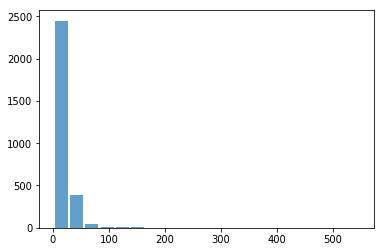

In [213]:
plt.hist(laptop_open_data['init_to_comple'], bins= 20, alpha=0.7, rwidth=0.85 )

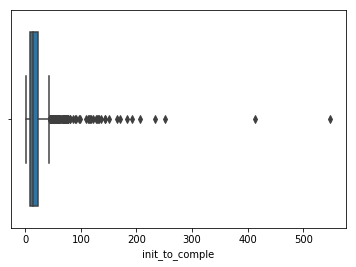

In [214]:
sns.boxplot(laptop_open_data['init_to_comple'])

In [203]:
laptop_upper_outlier = upper_outlier_selection(laptop_open_data['init_to_comple'])

In [382]:
laptop_lower_outlier = float(laptop_describe_transposed['25%'])

In [402]:
laptop_upper_min = laptop_upper_outlier
laptop_upper_max = laptop_upper_outlier*3

In [ ]:
#  Kết quả 
#  100% mẫu là nhỏ hơn 25%, lớn hơn upper_outlier*3
# Chọn mẫu 20% của danh sách từ upper_outlier đến upper_outlier*3

In [220]:
# Máy tính bảng
tablet_open_data = open_data[open_data['categoryname'] == 'Máy tính bảng']
tablet_open_data = tablet_open_data[tablet_open_data['init_to_comple'].isnull() == False]
tablet_describe = tablet_open_data.describe()

tablet_describe_transposed = tablet_describe.T

tablet_describe_transposed = tablet_describe_transposed.reset_index() 

In [344]:
tablet_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,280.0,15.813571,18.755269,2.466667,7.1625,11.808333,18.470833,246.95


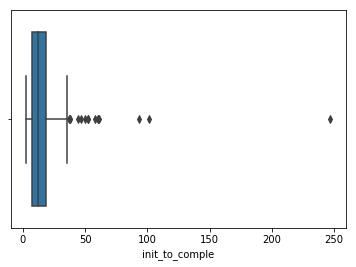

In [222]:
sns.boxplot(tablet_open_data['init_to_comple'])

In [223]:
tablet_upper_outlier = upper_outlier_selection(tablet_open_data['init_to_comple'])

In [383]:
tablet_lower_outlier = float(tablet_describe_transposed['25%'])

In [225]:
# kết quả
#  Cảnh báo 100% >= upper_outlier
# Cảnh báo 100% khi nhỏ hơn 25%

In [345]:
#  Điện thoại
phone_open_data = open_data[open_data['categoryname'] == 'Điện thoại']
phone_open_data = phone_open_data[phone_open_data['init_to_comple'].isnull() == False]
phone_describe = phone_open_data.describe()

phone_describe_transposed = phone_describe.T

phone_describe_transposed = phone_describe_transposed.reset_index()
# open_data[open_data['categoryname'] == '']['init_to_comple'].describe()

In [346]:
phone_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,2355.0,15.038146,15.616758,1.05,7.158333,11.55,18.091667,259.033333


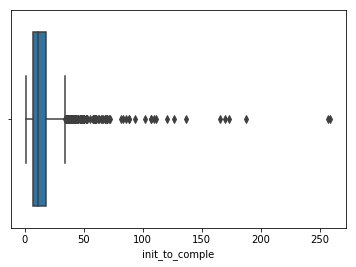

In [153]:
sns.boxplot(open_data[open_data['categoryname'] == 'Điện thoại']['init_to_comple'])

In [347]:
phone_upper_outlier = upper_outlier_selection(phone_open_data['init_to_comple'])

In [384]:
phone_lower_outlier = float(phone_describe_transposed['25%'])

In [403]:
phone_upper_min = phone_upper_outlier
phone_upper_max = phone_upper_outlier*2.5

In [360]:
#   Đồng hồ
watch_open_data = open_data[open_data['categoryname'] == 'Đồng hồ']
watch_open_data = watch_open_data[watch_open_data['init_to_comple'].isnull() == False]
watch_describe = watch_open_data.describe()

watch_describe_transposed = watch_describe.T

watch_describe_transposed = watch_describe_transposed.reset_index()

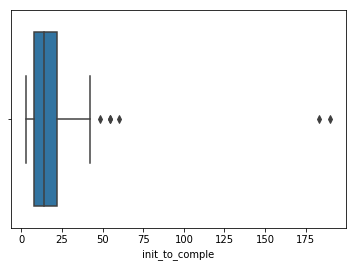

In [361]:
sns.boxplot(watch_open_data['init_to_comple'])

In [362]:
watch_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,164.0,18.269004,21.789868,2.883333,8.054167,13.85,21.9375,190.05


In [363]:
watch_upper_outlier = upper_outlier_selection(watch_open_data['init_to_comple'])

In [385]:
watch_lower_outlier = float(watch_describe_transposed['25%'])

In [231]:
#  Trang sức
ass_open_data = open_data[open_data['categoryname'] == 'Trang sức']
ass_open_data = ass_open_data[ass_open_data['init_to_comple'].isnull() == False]
ass_describe = ass_open_data.describe()

ass_describe_transposed = ass_describe.T

ass_describe_transposed = ass_describe_transposed.reset_index()

In [365]:
ass_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,404.0,12.504208,15.200287,1.383333,6.145833,9.025,13.5125,179.416667


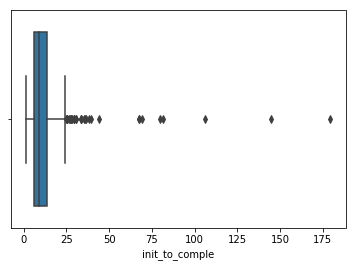

In [232]:
sns.boxplot(ass_open_data['init_to_comple'])

In [234]:
ass_upper_outlier = upper_outlier_selection(ass_open_data['init_to_comple'])

In [386]:
ass_lower_outlier = float(ass_describe_transposed['25%'])

In [367]:
#  Máy ảnh
camera_open_data = open_data[open_data['categoryname'] == 'Máy ảnh']
camera_open_data = camera_open_data[camera_open_data['init_to_comple'].isnull() == False]
camera_describe = camera_open_data.describe()

camera_describe_transposed = camera_describe.T

camera_describe_transposed = camera_describe_transposed.reset_index()

In [368]:
camera_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,142.0,36.687207,33.860527,5.55,17.370833,26.291667,44.2,198.4


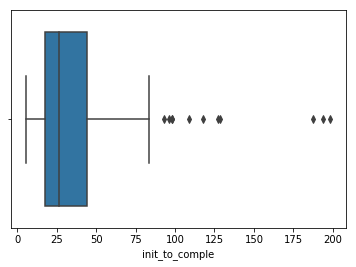

In [369]:
sns.boxplot(camera_open_data['init_to_comple'])

In [370]:
camera_upper_outlier = upper_outlier_selection(camera_open_data['init_to_comple'])

In [387]:
camera_lower_outlier = float(camera_describe_transposed['25%'])

In [ ]:
#  Trả ra full khi thời gian tạo lập HĐ nhỏ hơn 25% và >= ass_upper_outlierabs

In [236]:
#  Sim điện thoại
card_open_data = open_data[open_data['categoryname'] == 'Sim điện thoại']
card_open_data = card_open_data[card_open_data['init_to_comple'].isnull() == False]
card_describe = card_open_data.describe()

card_describe_transposed = card_describe.T

card_describe_transposed = card_describe_transposed.reset_index()

In [238]:
card_describe_transposed

,index,count,mean,std,min,25%,50%,75%,max
0,init_to_comple,3.0,17.038889,7.928593,8.383333,13.583333,18.783333,21.366667,23.95


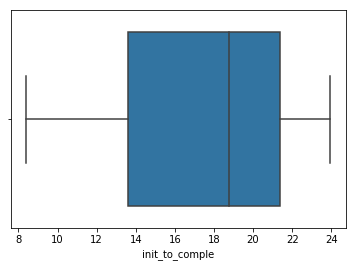

In [237]:
sns.boxplot(card_open_data['init_to_comple'])

In [163]:
# Tài sản khác
open_data[open_data['categoryname'] == 'Tài sản khác']['init_to_comple'].describe()

count      6.000000
mean      62.730556
std       82.093674
min        6.266667
25%       13.904167
50%       38.458333
75%       56.750000
max      224.633333
Name: init_to_comple, dtype: float64

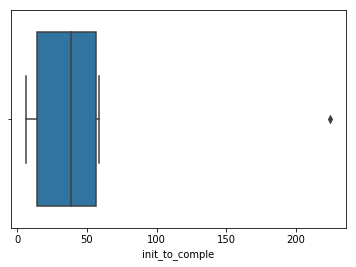

In [164]:
sns.boxplot(open_data[open_data['categoryname'] == 'Tài sản khác']['init_to_comple'])

In [366]:
open_data['categoryname'].unique()

array(['Đăng ký xe máy', 'Laptop', 'Điện thoại', 'Trang sức',
       'Đăng ký Ô tô', 'Xe máy', 'Máy tính bảng', 'Đồng hồ', 'Ô tô',
       'Máy ảnh', 'Sim điện thoại', 'Tài sản khác', 'Đồng hồ cao cấp',
       'Thiết bị định vị'], dtype=object)

In [418]:
full_sample_threshold = {'category_name': ['Đăng ký xe máy', 'Đăng ký Ô tô','Xe máy','Ô tô','Laptop','Máy tính bảng','Điện thoại','Đồng hồ','Trang sức', 'Máy ảnh'],
        'lower_threshold': [motor_title_lower_outlier,car_title_lower_outlier, motor_lower_outlier,car_lower_outlier *0.5,laptop_lower_outlier,tablet_lower_outlier,phone_lower_outlier,watch_lower_outlier,ass_lower_outlier,camera_lower_outlier],
        'upper_threshold': [motor_title_upper_outlier*2, car_title_upper_outlier, motor_upper_outlier*2, car_upper_outlier, laptop_upper_outlier*3,tablet_upper_outlier,phone_upper_outlier*2.5, watch_upper_outlier, ass_upper_outlier, camera_upper_outlier]}

In [419]:
full_sample_threshold_table = pd.DataFrame(full_sample_threshold, columns = ['category_name', 'lower_threshold', 'upper_threshold'])

In [420]:
full_sample_threshold_table = full_sample_threshold_table.reset_index()

In [421]:
full_sample_threshold_table

,index,category_name,lower_threshold,upper_threshold
0,0,Đăng ký xe máy,10.475000,476.166667
1,1,Đăng ký Ô tô,16.879167,532.291667
2,2,Xe máy,7.683333,65.950000
3,3,Ô tô,33.879167,236.706250
4,4,Laptop,9.166667,131.250000
5,5,Máy tính bảng,7.162500,35.433333
6,6,Điện thoại,7.158333,86.229167
7,7,Đồng hồ,8.054167,42.762500
8,8,Trang sức,6.145833,24.562500
9,9,Máy ảnh,17.370833,84.443750


In [408]:
part_sample_lower = {'category_name': ['Đăng ký xe máy', 'Đăng ký Ô tô'],
        'lower_threshold': [motor_title_lower_min, car_title_lower_min],
        'upper_threshold': [motor_title_lower_max, car_title_lower_max]}

In [410]:
part_sample_threshold_table_short = pd.DataFrame(part_sample_lower, columns = ['category_name', 'lower_threshold', 'upper_threshold'])

In [416]:
part_sample_upper = {'category_name': ['Đăng ký xe máy', 'Đăng ký Ô tô','Xe máy','Ô tô','Laptop','Điện thoại'],
        'lower_threshold': [motor_title_upper_min, car_title_upper_min, motor_upper_min, car_upper_min,laptop_upper_min, phone_upper_min],
        'upper_threshold': [motor_title_upper_max, car_title_upper_max, motor_upper_max, car_upper_max, laptop_upper_max, phone_upper_max]}

In [417]:
part_sample_threshold_table_long = pd.DataFrame(part_sample_upper, columns = ['category_name', 'lower_threshold', 'upper_threshold'])

In [423]:
part_sample_threshold_table_long

,category_name,lower_threshold,upper_threshold
0,Đăng ký xe máy,238.083333,476.166667
1,Đăng ký Ô tô,183.983333,532.291667
2,Xe máy,32.975000,65.950000
3,Ô tô,203.006250,236.706250
4,Laptop,43.750000,131.250000
5,Điện thoại,34.491667,86.229167


In [426]:
import xlsxwriter
writer = pd.ExcelWriter(r'pawn_process_theshold.xlsx', engine='xlsxwriter')
full_sample_threshold_table.to_excel(writer, sheet_name='full_sample')
part_sample_threshold_table_long.to_excel(writer, sheet_name='part_process_long')
part_sample_threshold_table_short.to_excel(writer, sheet_name = 'part_process_short')
# full_tb_dkot.to_excel(writer, sheet_name = 'full_tb_dkot', index = False)
# full_tb_dkxm.to_excel(writer, sheet_name = 'full_tb_dkxm', index = False)
# ontime_spdk_last_month.to_excel(writer, sheet_name = 'ontime_spdk_last_month', index = False)
# balance_pre_days.to_excel(writer, sheet_name= 'balance_pre_days_summ', index = False)
writer.save()

In [425]:
full_sample_threshold_table

,index,category_name,lower_threshold,upper_threshold
0,0,Đăng ký xe máy,10.475000,476.166667
1,1,Đăng ký Ô tô,16.879167,532.291667
2,2,Xe máy,7.683333,65.950000
3,3,Ô tô,33.879167,236.706250
4,4,Laptop,9.166667,131.250000
5,5,Máy tính bảng,7.162500,35.433333
6,6,Điện thoại,7.158333,86.229167
7,7,Đồng hồ,8.054167,42.762500
8,8,Trang sức,6.145833,24.562500
9,9,Máy ảnh,17.370833,84.443750
